In [1]:
# import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy
from scipy import signal
from numpy import *
!sudo apt-get install libportaudio2
!pip install sounddevice
import sounddevice as sd

from IPython.display import Audio

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

!pip install ffmpeg-python
# import mic_to_np_arr as mic
!wget -O mic_to_np_arr_TEMP.py https://raw.githubusercontent.com/AbrahamSteenhoek/RaspPi_DSP/main/mic_to_np_arr.py
import mic_to_np_arr_TEMP as mic

%matplotlib inline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (126 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 155222 files

In [28]:
def record_plot_audio():
  mic_audio, mic_sr = mic.get_audio()

  t = r_[0.0:len(mic_audio)]/mic_sr
  width, height = plt.figaspect(0.2)
  fig = plt.figure(figsize=(width,height))
  plt.plot(t, abs(mic_audio))
  plt.title('Recorded audio')
  plt.xlabel('time[s]')
  plt.show()

  mic_spectrum = np.fft.rfft(mic_audio, n=512)
  mic_spectrum_freq = np.fft.rfftfreq(mic_audio.size, d=1./mic_sr)
  mic_spectrum_abs = abs(mic_spectrum)

  # plot
  width, height = plt.figaspect(0.2)
  fig = plt.figure(figsize=(width,height))
  plt.plot(mic_spectrum_freq, abs(mic_spectrum))
  plt.xlabel("Frequency [Hz]")
  plt.ylabel("Magnitude")
  plt.title("Frequency response of recorded audio")

  return mic_audio, mic_sr, mic_spectrum, mic_spectrum_freq

def record_plot_audio2():
  mic_audio, mic_sr = mic.get_audio()

  t = r_[0.0:len(mic_audio)]/mic_sr
  width, height = plt.figaspect(0.2)
  fig = plt.figure(figsize=(width,height))
  plt.plot(t, abs(mic_audio))
  plt.title('Recorded audio')
  plt.xlabel('time[s]')
  plt.show()

  w, mic_spectrum = signal.freqz(mic_audio, worN=512)
  freq = w/pi*mic_sr/2
  # plot
  width, height = plt.figaspect(0.2)
  fig = plt.figure(figsize=(width,height))
  plt.plot(freq, abs(mic_spectrum))
  plt.xlabel("Frequency [Hz]")
  plt.ylabel("Magnitude")
  plt.title("Frequency response of recorded audio")

  return np.copy(mic_audio), mic_sr, mic_spectrum, freq

# Generating Chirp Pulses
Note that the width of the main lobe of the analytical signal (autocorrelation) depends on the BW of the chirp pulse. Because short chirp pulses are localized in time, we can separate echoes from targets that are close together in space. The shorter the pulse, the smaller the space that the sonar can distinguish.

However, one tradeoff from the short pulses is that there is less overall energy in the signal, so the SNR decreases. This creates a trade off in sonar resolution vs. SNR.

However, increasing the length of the length of the pulse, and also increasing the bandwidth allows us to both preserve SNR and improve resolution.



In [9]:
def GenChirpPulseA(N, f0, f1, fs):
    # Function generates an analytic function of a chirp pulse
    # Inputs:
    #     N = pulse length in samples
    #     f0     = starting frequency of chirp
    #     f1     = end frequency of chirp
    #     fs     = sampling frequency
    # Output:
    #     pulse_a  = analytic function of chirp pulse
    
    T = N/fs
    t = np.r_[0.0:N]/fs
    k = (f1-f0)/T
    phi_of_t = 2*pi*(f0 + k/2*t)*t
    pulse_a = exp(1j*phi_of_t)
    
    return pulse_a

In [15]:
def GenPulseTrain( pulse_a, N_repetitions, N_segments ):
  # Function generates a pulse train from a pulse. 
  # Inputs:
  #     pulse  = the pulse generated by genChirpPulse
  #     N_repetitions   = number of pulse repetitions
  #     N_segments   = length of pulse segment >= len(pulse)
  # Output:
  #     ptrain = pulse train
  num_zeros = N_segments - len( pulse_a )
  pulse_padded = pad( pulse_a, (0,num_zeros), 'constant', constant_values=(0,0))
  return tile( pulse_padded, N_repetitions )

Text(0.5, 1.0, 'Analytic function of chirp pulse')

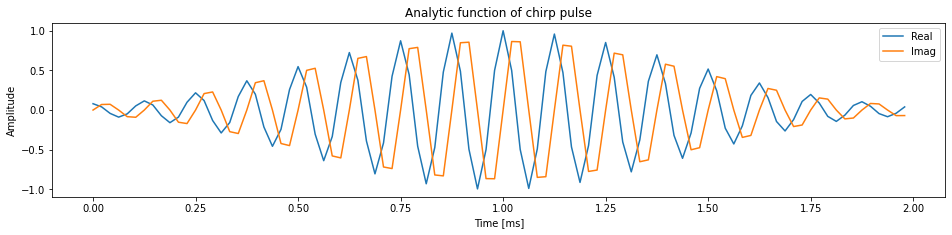

In [22]:
# test chirp pulse generation
fs = 48e3
N = 96
pulse_a = GenChirpPulseA( N, 8e3, 8e3, fs ) * signal.hamming(N)
pulse = pulse_a.real
t = r_[0:len(pulse_a)] / fs * 1e3

width,height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, real(pulse_a))
plt.plot(t, imag(pulse_a))
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.legend(('Real','Imag'))
plt.title('Analytic function of chirp pulse')

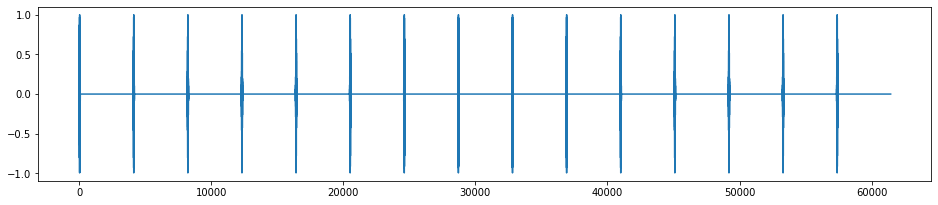

In [51]:
# test pulse train
N_rep = 15
N_seg = 4096
pulse_train = GenPulseTrain( pulse_a=real(pulse_a), N_repetitions=N_rep, N_segments=N_seg )

width,height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot( pulse_train )
Audio( data=pulse_train, rate=fs )

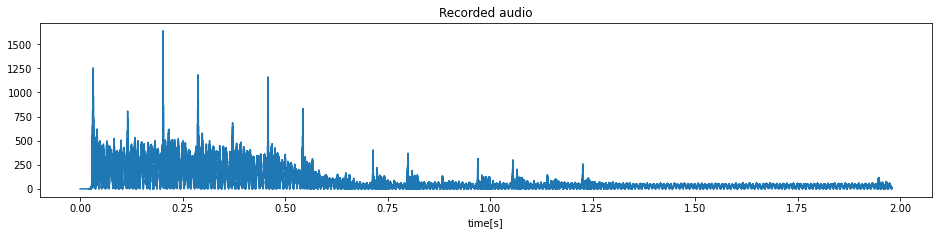

In [54]:
mic_audio, mic_sr = mic.get_audio()

t = r_[0.0:len(mic_audio)]/mic_sr
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(t, abs(mic_audio))
plt.title('Recorded audio')
plt.xlabel('time[s]')
plt.show()

<Figure size 1152x230.4 with 0 Axes>

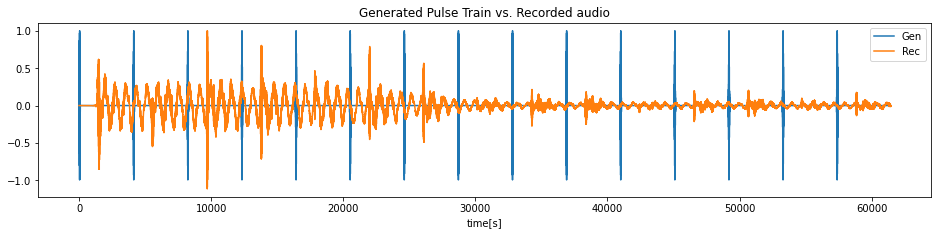

In [55]:
# print(mic_audio.size)
# print(pulse_train.size)
pulse_train_rec = np.copy(mic_audio)
trim = min(pulse_train_rec.size, pulse_train.size)
# print(trim)

pulse_train = pulse_train[0:trim]
pulse_train_rec = pulse_train_rec[0:trim]


width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(pulse_train/max(pulse_train))
plt.plot(pulse_train_rec/max(pulse_train_rec))
plt.title('Generated Pulse Train vs. Recorded audio')
plt.xlabel('time[s]')
plt.legend(('Gen', 'Rec'))
plt.show()

In [63]:
i = 0
for elem in pulse_train_rec:
  # print(f'[{i}]: {pulse_train_rec[elem]/max(pulse_train_rec)}')
  if ( pulse_train_rec[i]/max(pulse_train_rec) > 0.2 ):
    print(i)
    break
  i+=1

1382


Extract a single pulse from the pulse train

Text(0.5, 1.0, 'Single transceived pulse (plus echoes)')

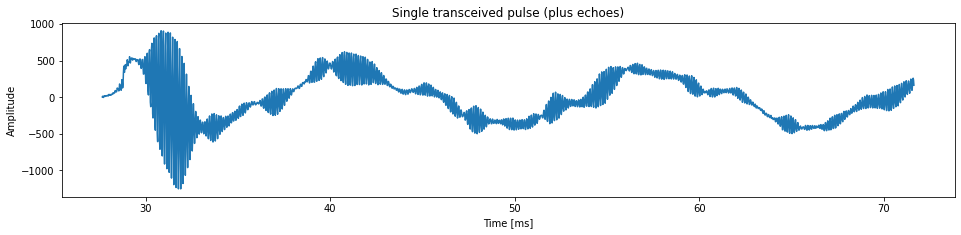

In [67]:
start = 1382
ind = np.argmax( abs(pulse_train_rec[start::]) > 0.75 * max(abs(pulse_train_rec[start::])) ) + start
inds = r_[ind-2*N:ind+20*N]
pulse_rcv = pulse_train_rec[inds]
t = r_[0:len(pulse_train_rec)]/fs * 1e3

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t[inds], pulse_rcv)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Single transceived pulse (plus echoes)")